# building 1-100 데이터 준비

- # 건물기타 15개, 공공 8개, 대학교 8개, 데이터센터 5개

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.7/118.7 kB 13.3 MB/s eta 0:00:00


In [ ]:
from lightgbm import LGBMRegressor, early_stopping
from xgboost import XGBRegressor, callback

from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder

from sktime.forecasting.model_selection import temporal_train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer


In [ ]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

DATA_PATH = '/content/drive/MyDrive/데이콘 캐글 컴페티션/DACON_23.07_PowerConsumption/'
SEED = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
train = pd.read_csv(f"{DATA_PATH}train.csv")
test = pd.read_csv(f"{DATA_PATH}test.csv")
building = pd.read_csv(f"{DATA_PATH}building_info.csv")
submission = pd.read_csv(f"{DATA_PATH}sample_submission.csv")

In [ ]:
def _smape(true, pred):
    true = np.array(true)
    pred = np.array(pred)
    output = np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100
    return output
smape = make_scorer(_smape, greater_is_better=False)

In [ ]:
train_ft = pd.merge(train,building,on='건물번호',how='left')

In [ ]:
test_ft = pd.merge(test,building,on='건물번호',how='left')

### 칼럼 처리 및 영문화

- object 칼럼 처리:  '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)'

In [ ]:
train_ft['태양광용량(kW)'] = train_ft['태양광용량(kW)'].replace('-', np.nan).astype(float)
train_ft['ESS저장용량(kWh)'] = train_ft['ESS저장용량(kWh)'].replace('-', np.nan).astype(float)
train_ft['PCS용량(kW)'] = train_ft['PCS용량(kW)'].replace('-', np.nan).astype(float)

In [ ]:
test_ft['태양광용량(kW)'] = test_ft['태양광용량(kW)'].replace('-', np.nan).astype(float)
test_ft['ESS저장용량(kWh)'] = test_ft['ESS저장용량(kWh)'].replace('-', np.nan).astype(float)
test_ft['PCS용량(kW)'] = test_ft['PCS용량(kW)'].replace('-', np.nan).astype(float)

In [ ]:
train_ft

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28,건물기타,110634.00,39570.00,NaN,NaN,NaN
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36,건물기타,110634.00,39570.00,NaN,NaN,NaN
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88,건물기타,110634.00,39570.00,NaN,NaN,NaN
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76,건물기타,110634.00,39570.00,NaN,NaN,NaN
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40,건물기타,110634.00,39570.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,20220824 19,23.1,NaN,0.9,86.0,0.5,NaN,881.04,호텔및리조트,57497.84,40035.23,NaN,NaN,NaN
203996,100_20220824 20,100,20220824 20,22.4,NaN,1.3,86.0,0.0,NaN,798.96,호텔및리조트,57497.84,40035.23,NaN,NaN,NaN
203997,100_20220824 21,100,20220824 21,21.3,NaN,1.0,92.0,NaN,NaN,825.12,호텔및리조트,57497.84,40035.23,NaN,NaN,NaN
203998,100_20220824 22,100,20220824 22,21.0,NaN,0.3,94.0,NaN,NaN,640.08,호텔및리조트,57497.84,40035.23,NaN,NaN,NaN


In [ ]:
train_ft.isnull().sum()

num_date_time         0
건물번호                  0
일시                    0
기온(C)                 0
강수량(mm)          160069
풍속(m/s)              19
습도(%)                 9
일조(hr)            75182
일사(MJ/m2)         87913
전력소비량(kWh)            0
건물유형                  0
연면적(m2)               0
냉방면적(m2)              0
태양광용량(kW)        130560
ESS저장용량(kWh)     193800
PCS용량(kW)        193800
dtype: int64

- object 칼럼 처리 : 'num_date_time'제거 , '일시' to datetime

In [ ]:
train_ft['일시'] = pd.to_datetime(train_ft['일시'])

# 월, 일, 시간 추출하여 새로운 칼럼 추가
train_ft['월'] = train_ft['일시'].dt.month
train_ft['일'] = train_ft['일시'].dt.day
train_ft['시간'] = train_ft['일시'].dt.hour

# 요일 추출하여 새로운 칼럼 추가 (월요일: 0, 일요일: 6)
train_ft['요일'] = train_ft['일시'].dt.weekday

#일자번호 추가
train_ft['일자번호'] = train_ft['일시'].dt.dayofyear

#주간번호 추가
# train_ft['주간번호'] = train_ft['일시'].dt.isocalendar().week.astype(float)


In [ ]:
test_ft['일시'] = pd.to_datetime(train_ft['일시'])

# 월, 일, 시간 추출하여 새로운 칼럼 추가
test_ft['월'] = test_ft['일시'].dt.month
test_ft['일'] = test_ft['일시'].dt.day
test_ft['시간'] = test_ft['일시'].dt.hour

# 요일 추출하여 새로운 칼럼 추가 (월요일: 0, 일요일: 6)
test_ft['요일'] = test_ft['일시'].dt.weekday

#일자번호 추가
test_ft['일자번호'] = test_ft['일시'].dt.dayofyear

#주간번호 추가
# test_ft['주간번호'] = test_ft['일시'].dt.isocalendar().week


In [ ]:
train_ft = train_ft.drop('num_date_time', axis=1)
test_ft = test_ft.drop('num_date_time', axis=1)

In [ ]:
# train_ft.fillna(0)
# test_ft.fillna(0)

- 칼럼추가

- 데이터 칼럼 영문화

In [ ]:
train_ft.columns

Index(['건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)',
       '일사(MJ/m2)', '전력소비량(kWh)', '건물유형', '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)',
       'ESS저장용량(kWh)', 'PCS용량(kW)', '월', '일', '시간', '요일', '일자번호'],
      dtype='object')

In [ ]:
# 변수 영문명으로 변경
train_eng_cols = ['building_num', 'date_time', 'temp', 'precip', 'wind_ms', 'humidity', 'sunshine',
                  'solar_rad', 'energy_consum', 'building_type', 'floor_area', 'cooling_area', 'solar_capa',
                  'ess_capa','pcs_capa','month','day','hour','day_of_week','day_of_year']

train_ft.columns = train_eng_cols
# test_df.columns = test_eng_cols

In [ ]:
test_eng_cols = ['building_num', 'date_time', 'temp', 'precip', 'wind_ms', 'humidity','building_type', 'floor_area',
                 'cooling_area', 'solar_capa', 'ess_capa','pcs_capa','month','day','hour',
                 'day_of_week','day_of_year']

test_ft.columns = test_eng_cols

### 유형 및 태양광 여부 확인

In [ ]:
cols = ['building_num','building_type']

In [ ]:
pd.pivot_table(train_ft, values='building_type', index='building_num', aggfunc='first')

,building_type
building_num,
1,건물기타
2,건물기타
3,건물기타
4,건물기타
5,건물기타
...,...
96,호텔및리조트
97,호텔및리조트
98,호텔및리조트


In [ ]:
tmp = pd.DataFrame(train_ft.groupby('building_num')['solar_capa','solar_rad','sunshine'].sum())

<ipython-input-22-c53d362eb6d4>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = pd.DataFrame(train_ft.groupby('building_num')['solar_capa','solar_rad','sunshine'].sum())


In [ ]:
tmp

,solar_capa,solar_rad,sunshine
building_num,,,
1,0.0,1257.88,353.5
2,0.0,1258.40,353.5
3,81600.0,1257.88,353.5
4,122400.0,1257.88,353.5
5,0.0,1257.88,353.5
...,...,...,...
96,0.0,1569.57,485.3
97,0.0,1705.98,628.7
98,0.0,0.00,535.4


In [ ]:
mask = tmp['solar_capa'] > 0
tmp[mask]

,solar_capa,solar_rad,sunshine
building_num,,,
3,81600.0,1257.88,353.5
4,122400.0,1257.88,353.5
11,912288.0,0.00,343.0
12,266424.0,1330.40,470.1
14,114240.0,1450.14,457.2
16,40800.0,1470.97,454.7
18,132192.0,1330.40,470.1
21,142800.0,1388.12,444.8
22,224400.0,1363.69,467.0


### 결측치 처리
- sunshine, sun_rad : 건물별로 시간대별 평균으로 채움 : 오전 6시~ 오후 8시 사이 값 존재 (이외 시간은 해 없어 0인 것으로)
- humidity, wind_ms 는 연속적인 값이므로 이전값으로 ffill함

- solar_capa 있는 곳들에서는 태양광 발전하므로 sunshine, sun_rad 활용예정 / ess, pcs는 칼럼있는 건물 한정해서 사용
- precip??? : 강수량 없는 것으로 가정

In [ ]:
train_ft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204000 entries, 0 to 203999
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   building_num   204000 non-null  int64         
 1   date_time      204000 non-null  datetime64[ns]
 2   temp           204000 non-null  float64       
 3   precip         43931 non-null   float64       
 4   wind_ms        203981 non-null  float64       
 5   humidity       203991 non-null  float64       
 6   sunshine       128818 non-null  float64       
 7   solar_rad      116087 non-null  float64       
 8   energy_consum  204000 non-null  float64       
 9   building_type  204000 non-null  object        
 10  floor_area     204000 non-null  float64       
 11  cooling_area   204000 non-null  float64       
 12  solar_capa     73440 non-null   float64       
 13  ess_capa       10200 non-null   float64       
 14  pcs_capa       10200 non-null   float64       
 15  

In [ ]:
test_ft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16800 entries, 0 to 16799
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   building_num   16800 non-null  int64         
 1   date_time      16800 non-null  datetime64[ns]
 2   temp           16800 non-null  float64       
 3   precip         16800 non-null  float64       
 4   wind_ms        16800 non-null  float64       
 5   humidity       16800 non-null  int64         
 6   building_type  16800 non-null  object        
 7   floor_area     16800 non-null  float64       
 8   cooling_area   16800 non-null  float64       
 9   solar_capa     6048 non-null   float64       
 10  ess_capa       840 non-null    float64       
 11  pcs_capa       840 non-null    float64       
 12  month          16800 non-null  int64         
 13  day            16800 non-null  int64         
 14  hour           16800 non-null  int64         
 15  day_of_week    1680

In [ ]:
train_ft.isna().sum()

building_num          0
date_time             0
temp                  0
precip           160069
wind_ms              19
humidity              9
sunshine          75182
solar_rad         87913
energy_consum         0
building_type         0
floor_area            0
cooling_area          0
solar_capa       130560
ess_capa         193800
pcs_capa         193800
month                 0
day                   0
hour                  0
day_of_week           0
day_of_year           0
dtype: int64

In [ ]:
train_ft.isna().sum()

building_num          0
date_time             0
temp                  0
precip           160069
wind_ms              19
humidity              9
sunshine          75182
solar_rad         87913
energy_consum         0
building_type         0
floor_area            0
cooling_area          0
solar_capa       130560
ess_capa         193800
pcs_capa         193800
month                 0
day                   0
hour                  0
day_of_week           0
day_of_year           0
dtype: int64

In [ ]:
# test_ft.isna().sum()

In [ ]:
mask = train_ft['building_num'] == 1
train_ft[mask]

,building_num,date_time,temp,precip,wind_ms,humidity,sunshine,solar_rad,energy_consum,building_type,floor_area,cooling_area,solar_capa,ess_capa,pcs_capa,month,day,hour,day_of_week,day_of_year
0,1,2022-06-01 00:00:00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28,건물기타,110634.0,39570.0,NaN,NaN,NaN,6,1,0,2,152
1,1,2022-06-01 01:00:00,18.0,NaN,1.1,45.0,NaN,NaN,1047.36,건물기타,110634.0,39570.0,NaN,NaN,NaN,6,1,1,2,152
2,1,2022-06-01 02:00:00,17.7,NaN,1.5,45.0,NaN,NaN,974.88,건물기타,110634.0,39570.0,NaN,NaN,NaN,6,1,2,2,152
3,1,2022-06-01 03:00:00,16.7,NaN,1.4,48.0,NaN,NaN,953.76,건물기타,110634.0,39570.0,NaN,NaN,NaN,6,1,3,2,152
4,1,2022-06-01 04:00:00,18.4,NaN,2.8,43.0,NaN,NaN,986.40,건물기타,110634.0,39570.0,NaN,NaN,NaN,6,1,4,2,152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,1,2022-08-24 19:00:00,25.5,NaN,2.9,63.0,0.1,0.19,2517.12,건물기타,110634.0,39570.0,NaN,NaN,NaN,8,24,19,2,236
2036,1,2022-08-24 20:00:00,25.0,NaN,2.6,66.0,0.0,0.01,2208.96,건물기타,110634.0,39570.0,NaN,NaN,NaN,8,24,20,2,236
2037,1,2022-08-24 21:00:00,24.6,NaN,1.3,67.0,NaN,NaN,1806.24,건물기타,110634.0,39570.0,NaN,NaN,NaN,8,24,21,2,236
2038,1,2022-08-24 22:00:00,24.1,NaN,2.1,70.0,NaN,NaN,1387.20,건물기타,110634.0,39570.0,NaN,NaN,NaN,8,24,22,2,236


- sunshine

In [ ]:
#일조량 시간별 평균으로 train_ft 결측치 처리, test_ft에 sunshine값 추가

avg_sunshine_train = train_ft.groupby(['building_num', 'hour'])['sunshine'].mean().reset_index()
avg_sunshine_train.rename(columns={'sunshine': 'sunshine_avg'}, inplace=True)

# 결측치 채우기
train_ft = train_ft.merge(avg_sunshine_train, on=['building_num', 'hour'], how='left')
train_ft['sunshine'] = train_ft['sunshine'].fillna(train_ft['sunshine_avg'])

# 불필요한 열 제거
train_ft.drop('sunshine_avg', axis=1, inplace=True)


In [ ]:
# test 데이터에 일조량 추가
test_ft = test_ft.merge(avg_sunshine_train, on=['building_num', 'hour'], how='left')
test_ft.rename(columns={'sunshine_avg': 'sunshine'}, inplace=True)

- solar rad

In [ ]:
₩

In [ ]:
test_ft = test_ft.merge(avg_solar_rad_train, on=['building_num', 'hour'], how='left')
test_ft.rename(columns={'solar_rad_avg': 'solar_rad'}, inplace=True)

In [ ]:
train_ft['sunshine'] = train_ft['sunshine'].fillna(0)
test_ft['sunshine'] = test_ft['sunshine'].fillna(0)

train_ft['solar_rad'] = train_ft['solar_rad'].fillna(0)
test_ft['solar_rad'] = test_ft['solar_rad'].fillna(0)

- 풍속 결측치

In [ ]:
train_ft['wind_ms'].min(), train_ft['wind_ms'].max()

(0.0, 13.3)

In [ ]:
train_ft['wind_ms'].fillna(method='ffill', inplace=True)

test_ft['wind_ms'].fillna(method='ffill', inplace=True)

- 습도 결측치

In [ ]:
train_ft['humidity'].min(), train_ft['humidity'].max()

(13.0, 100.0)

In [ ]:
train_ft['humidity'].fillna(method='ffill', inplace=True)

test_ft['humidity'].fillna(method='ffill', inplace=True)

- 강수량 결측치

In [ ]:
train_ft['precip'].min(), train_ft['precip'].max()

(0.0, 92.2)

In [ ]:
train_ft['precip'].fillna(0, inplace=True)

test_ft['precip'].fillna(0, inplace=True)

- 태양광용량, ess, pcs 결측치 : 값없으면 0인걸로

In [ ]:
train_ft.fillna(0, inplace=True)

test_ft.fillna(0, inplace=True)

In [ ]:
train_ft.isna().sum().sum(), test_ft.isna().sum().sum()

(0, 0)

### 6/1제거

### 피처 추가

In [ ]:
# 주말 여부 추가
train_ft['weekend'] = train_ft['day'].isin([5, 6]) + 0

# 시간에 대한 cos, sin 피처 추가
train_ft['cos_hour'] = np.cos(2 * np.pi * train_ft['hour'] / 24)  # 하루 기준으로 cos 값 추가
train_ft['sin_hour'] = np.sin(2 * np.pi * train_ft['hour'] / 24)  # 하루 기준으로 sin 값 추가

# 일에 대한 주기성을 감지하기 위한 피처 추가
train_ft['day_of_year'] = train_ft['month'] * 30 + train_ft['day']  # 간단한 근사 값
train_ft['cos_day_of_year'] = np.cos(2 * np.pi * train_ft['day_of_year'] / 365)
train_ft['sin_day_of_year'] = np.sin(2 * np.pi * train_ft['day_of_year'] / 365)

# 요일에 대한 sin, cos 피처 추가
train_ft['cos_weekday'] = np.cos(2 * np.pi * train_ft['day_of_week'] / 7)  # 7일 기준으로 cos 값 추가
train_ft['sin_weekday'] = np.sin(2 * np.pi * train_ft['day_of_week'] / 7)  # 7일 기준으로 sin 값 추가

# 주차별 cos, sin 피처 추가
train_ft['cos_week'] = np.cos(2 * np.pi * train_ft['day_of_year'] / 52)  # 52주 기준으로 cos 값 추가
train_ft['sin_week'] = np.sin(2 * np.pi * train_ft['day_of_year'] / 52)  # 52주 기준으로 sin 값 추가

# 월에 대한 cos, sin 피처 추가
train_ft['cos_month'] = np.cos(2 * np.pi * train_ft['month'] / 12)  # 12달 기준으로 cos 값 추가
train_ft['sin_month'] = np.sin(2 * np.pi * train_ft['month'] / 12)  # 12달 기준으로 sin 값 추가


In [ ]:
# 주말 여부 추가
test_ft['weekend'] = test_ft['day'].isin([5, 6]) + 0

# 시간에 대한 cos, sin 피처 추가
test_ft['cos_hour'] = np.cos(2 * np.pi * test_ft['hour'] / 24)  # 하루 기준으로 cos 값 추가
test_ft['sin_hour'] = np.sin(2 * np.pi * test_ft['hour'] / 24)  # 하루 기준으로 sin 값 추가

# 일에 대한 주기성을 감지하기 위한 피처 추가
test_ft['day_of_year'] = test_ft['month'] * 30 + test_ft['day']  # 간단한 근사 값
test_ft['cos_day_of_year'] = np.cos(2 * np.pi * test_ft['day_of_year'] / 365)
test_ft['sin_day_of_year'] = np.sin(2 * np.pi * test_ft['day_of_year'] / 365)

# 요일에 대한 sin, cos 피처 추가
test_ft['cos_weekday'] = np.cos(2 * np.pi * test_ft['day_of_week'] / 7)  # 7일 기준으로 cos 값 추가
test_ft['sin_weekday'] = np.sin(2 * np.pi * test_ft['day_of_week'] / 7)  # 7일 기준으로 sin 값 추가

# 주차별 cos, sin 피처 추가
test_ft['cos_week'] = np.cos(2 * np.pi * test_ft['day_of_year'] / 52)  # 52주 기준으로 cos 값 추가
test_ft['sin_week'] = np.sin(2 * np.pi * test_ft['day_of_year'] / 52)  # 52주 기준으로 sin 값 추가

# 월에 대한 cos, sin 피처 추가
test_ft['cos_month'] = np.cos(2 * np.pi * test_ft['month'] / 12)  # 12달 기준으로 cos 값 추가
test_ft['sin_month'] = np.sin(2 * np.pi * test_ft['month'] / 12)  # 12달 기준으로 sin 값 추가


In [ ]:
train_ft['discomfort'] = 0.81 * train_ft['temp'] + 0.01 * train_ft['humidity'] * (0.99 * train_ft['temp'] - 14.3) + 46.3

train_ft['THI'] = 0.81 * train_ft['temp'] + 0.01 * train_ft['humidity'] * (0.99 * train_ft['temp'] - 14.3) + 46.3

train_ft['cooling_ratio'] = train_ft['cooling_area'] / train_ft['floor_area']

In [ ]:
test_ft['discomfort'] = 0.81 * test_ft['temp'] + 0.01 * test_ft['humidity'] * (0.99 * test_ft['temp'] - 14.3) + 46.3

test_ft['THI'] = 0.81 * test_ft['temp'] + 0.01 * test_ft['humidity'] * (0.99 * test_ft['temp'] - 14.3) + 46.3

test_ft['cooling_ratio'] = test_ft['cooling_area'] / test_ft['floor_area']


In [ ]:
#태양광 발전량

train_ft['solar_gen'] = train_ft['solar_rad'] * train_ft['sunshine'] * train_ft['solar_capa'] * 0.15  #0.15 발전효율 (15%~22%)

# train_ft['final_solar_gen'] = train_ft['solar_gen'] * train_ft['ess_capa'] * train_ft['pcs_capa'] # PCS와 ESS를 고려한 최종 발전량 계산


In [ ]:
test_ft['solar_gen'] = test_ft['solar_rad'] * test_ft['sunshine'] * test_ft['solar_capa'] * 0.15

# test_ft['final_solar_gen'] = test_ft['solar_gen'] * test_ft['ess_capa'] * test_ft['pcs_capa'] # PCS와 ESS를 고려한 최종 발전량 계산

### feature importance

In [ ]:
train_ft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204000 entries, 0 to 203999
Data columns (total 35 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   building_num     204000 non-null  int64         
 1   date_time        204000 non-null  datetime64[ns]
 2   temp             204000 non-null  float64       
 3   precip           204000 non-null  float64       
 4   wind_ms          204000 non-null  float64       
 5   humidity         204000 non-null  float64       
 6   sunshine         204000 non-null  float64       
 7   solar_rad        204000 non-null  float64       
 8   energy_consum    204000 non-null  float64       
 9   building_type    204000 non-null  object        
 10  floor_area       204000 non-null  float64       
 11  cooling_area     204000 non-null  float64       
 12  solar_capa       204000 non-null  float64       
 13  ess_capa         204000 non-null  float64       
 14  pcs_capa         204

In [ ]:
train_ft

,building_num,date_time,temp,precip,wind_ms,humidity,sunshine,solar_rad,energy_consum,building_type,...,cos_weekday,sin_weekday,cos_week,sin_week,cos_month,sin_month,discomfort,THI,cooling_ratio,solar_gen
0,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,0.0,0.0,1085.28,건물기타,...,-0.222521,0.974928,-0.992709,0.120537,-1.0,1.224647e-16,63.09388,63.09388,0.357666,0.0
1,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,0.0,0.0,1047.36,건물기타,...,-0.222521,0.974928,-0.992709,0.120537,-1.0,1.224647e-16,62.46400,62.46400,0.357666,0.0
2,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,0.0,0.0,974.88,건물기타,...,-0.222521,0.974928,-0.992709,0.120537,-1.0,1.224647e-16,62.08735,62.08735,0.357666,0.0
3,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,0.0,0.0,953.76,건물기타,...,-0.222521,0.974928,-0.992709,0.120537,-1.0,1.224647e-16,60.89884,60.89884,0.357666,0.0
4,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,0.0,0.0,986.40,건물기타,...,-0.222521,0.974928,-0.992709,0.120537,-1.0,1.224647e-16,62.88788,62.88788,0.357666,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,2022-08-24 19:00:00,23.1,0.0,0.9,86.0,0.5,0.0,881.04,호텔및리조트,...,-0.222521,0.974928,0.885456,0.464723,-0.5,-8.660254e-01,72.38034,72.38034,0.696291,0.0
203996,100,2022-08-24 20:00:00,22.4,0.0,1.3,86.0,0.0,0.0,798.96,호텔및리조트,...,-0.222521,0.974928,0.885456,0.464723,-0.5,-8.660254e-01,71.21736,71.21736,0.696291,0.0
203997,100,2022-08-24 21:00:00,21.3,0.0,1.0,92.0,0.0,0.0,825.12,호텔및리조트,...,-0.222521,0.974928,0.885456,0.464723,-0.5,-8.660254e-01,69.79704,69.79704,0.696291,0.0
203998,100,2022-08-24 22:00:00,21.0,0.0,0.3,94.0,0.0,0.0,640.08,호텔및리조트,...,-0.222521,0.974928,0.885456,0.464723,-0.5,-8.660254e-01,69.41060,69.41060,0.696291,0.0


In [ ]:
from xgboost import XGBRegressor
import numpy as np

# 데이터 로드 및 전처리
# 예시로 간단한 데이터 생성
cols = ['energy_consum', 'date_time', 'building_type']
X = train_ft.drop(columns=cols, axis=1)
feature_names = X.columns  # 특성의 이름을 저장

y = train_ft['energy_consum']  # 타겟 변수

# XGBoost 모델 생성
model = XGBRegressor(random_state=42)
model.fit(X, y)

# 특성 중요도 출력 및 정렬
feature_importances = model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

print("Feature Importances:")
for i, idx in enumerate(sorted_indices):
    feature_name = feature_names[idx]
    importance = feature_importances[idx]
    print(f"{i + 1}. Feature: {feature_name}, Importance: {importance:.4f}")



Feature Importances:
1. Feature: floor_area, Importance: 0.3097
2. Feature: cooling_ratio, Importance: 0.2561
3. Feature: building_num, Importance: 0.0964
4. Feature: solar_rad, Importance: 0.0571
5. Feature: cooling_area, Importance: 0.0474
6. Feature: solar_capa, Importance: 0.0431
7. Feature: pcs_capa, Importance: 0.0410
8. Feature: cos_hour, Importance: 0.0393
9. Feature: day_of_week, Importance: 0.0226
10. Feature: ess_capa, Importance: 0.0160
11. Feature: discomfort, Importance: 0.0153
12. Feature: hour, Importance: 0.0140
13. Feature: day_of_year, Importance: 0.0100
14. Feature: sin_hour, Importance: 0.0079
15. Feature: weekend, Importance: 0.0043
16. Feature: month, Importance: 0.0030
17. Feature: day, Importance: 0.0022
18. Feature: sin_weekday, Importance: 0.0020
19. Feature: precip, Importance: 0.0019
20. Feature: solar_gen, Importance: 0.0019
21. Feature: temp, Importance: 0.0018
22. Feature: cos_weekday, Importance: 0.0018
23. Feature: sin_week, Importance: 0.0013
24. Feat

Feature Importances:
1. Feature: floor_area, Importance: 0.3097
2. Feature: cooling_ratio, Importance: 0.2561
3. Feature: building_num, Importance: 0.0964
4. Feature: solar_rad, Importance: 0.0571
5. Feature: cooling_area, Importance: 0.0474
6. Feature: solar_capa, Importance: 0.0431
7. Feature: pcs_capa, Importance: 0.0410
8. Feature: cos_hour, Importance: 0.0393
9. Feature: day_of_week, Importance: 0.0226
10. Feature: ess_capa, Importance: 0.0160
11. Feature: discomfort, Importance: 0.0153
12. Feature: hour, Importance: 0.0140
13. Feature: day_of_year, Importance: 0.0100
14. Feature: sin_hour, Importance: 0.0079
15. Feature: weekend, Importance: 0.0043
16. Feature: month, Importance: 0.0030
17. Feature: day, Importance: 0.0022
18. Feature: sin_weekday, Importance: 0.0020
19. Feature: precip, Importance: 0.0019
20. Feature: solar_gen, Importance: 0.0019
21. Feature: temp, Importance: 0.0018
22. Feature: cos_weekday, Importance: 0.0018
23. Feature: sin_week, Importance: 0.0013
24. Feat

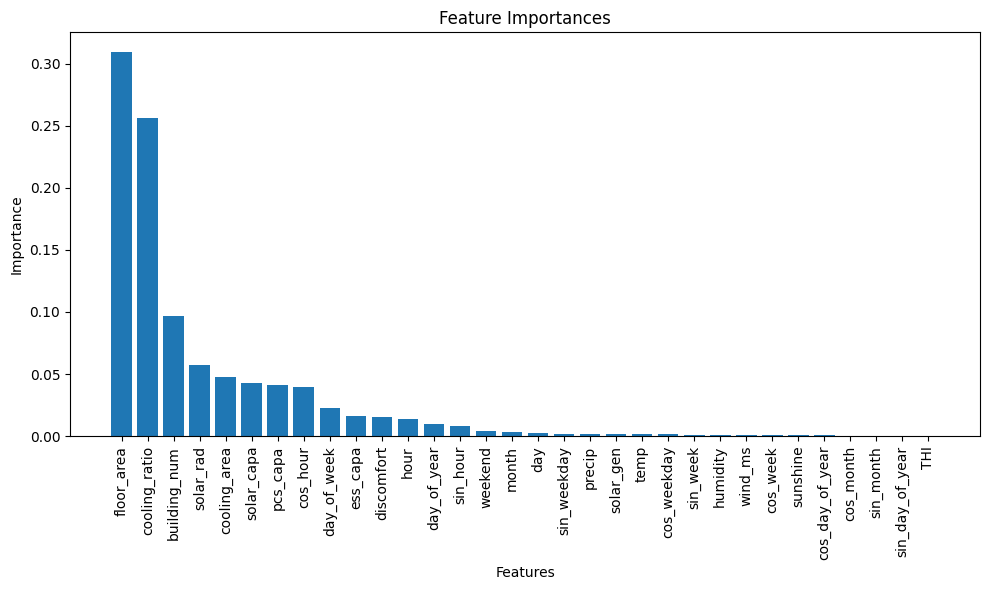

In [ ]:
import pandas as pd
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리 (여기서는 예시 데이터를 생성합니다)
cols = ['energy_consum', 'date_time', 'building_type']
X = train_ft.drop(columns=cols, axis=1)
feature_names = X.columns  # 특성의 이름을 저장

y = train_ft['energy_consum']  # 타겟 변수

# XGBoost 모델 생성
model = XGBRegressor(random_state=42)
model.fit(X, y)

# 피쳐 중요도 출력 및 시각화
feature_importances = model.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]

print("Feature Importances:")
for i, idx in enumerate(sorted_indices):
    feature_name = feature_names[idx]
    importance = feature_importances[idx]
    print(f"{i + 1}. Feature: {feature_name}, Importance: {importance:.4f}")

# 피쳐 중요도 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices])
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.531232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2648
[LightGBM] [Info] Number of data points in the train set: 204000, number of used features: 32
[LightGBM] [Info] Start training from score 2451.036462
Feature Importances:
1. Feature: building_num, Importance: 730.0000
2. Feature: floor_area, Importance: 545.0000
3. Feature: cooling_area, Importance: 316.0000
4. Feature: cooling_ratio, Importance: 297.0000
5. Feature: hour, Importance: 184.0000
6. Feature: day_of_week, Importance: 165.0000
7. Feature: solar_capa, Importance: 151.0000
8. Feature: cos_hour, Importance: 121.0000
9. Feature: solar_rad, Importance: 95.0000
10. Feature: day_of_year, Importance: 69.0000
11. Feature: discomfort, Importance: 60.0000
12. Feature: sin_hour, Importance: 56.0000
13. Feature: ess_capa, Importance: 45.0000
14. Feature: day, Importance: 26.0000
15. Feature:

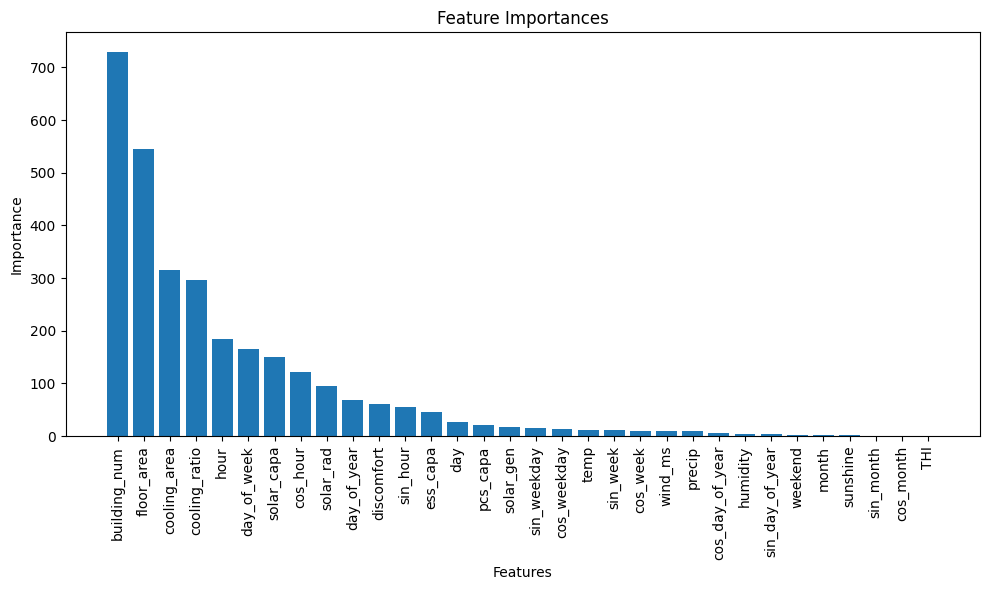

In [ ]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리 (여기서는 예시 데이터를 생성합니다)
cols = ['energy_consum', 'date_time', 'building_type']
X = train_ft.drop(columns=cols, axis=1)
feature_names = X.columns  # 특성의 이름을 저장

y = train_ft['energy_consum']  # 타겟 변수

# LightGBM 모델 생성
model = lgb.LGBMRegressor(random_state=42)
model.fit(X, y)

# 피쳐 중요도 출력 및 시각화
feature_importances = model.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]

print("Feature Importances:")
for i, idx in enumerate(sorted_indices):
    feature_name = feature_names[idx]
    importance = feature_importances[idx]
    print(f"{i + 1}. Feature: {feature_name}, Importance: {importance:.4f}")

# 피쳐 중요도 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices])
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 4.6 MB/s eta 0:00:00


#### shap value
- 최상단 feature : floor area, building num, cooling ratio 이므로 건물별 따로 예측이 더 나음
-

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


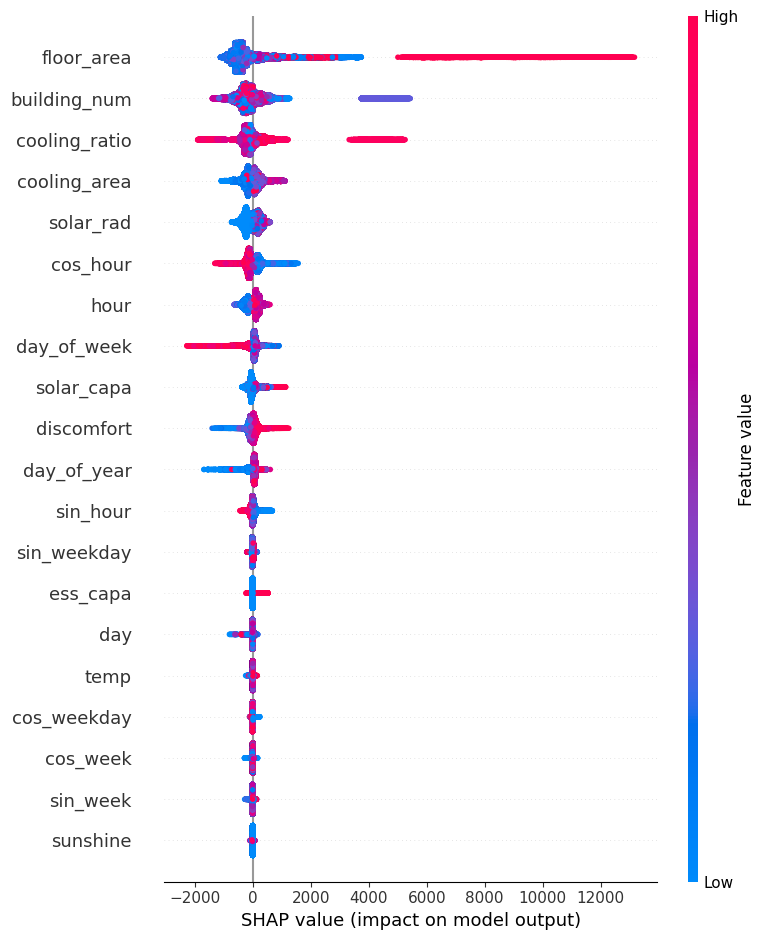

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import shap

# 데이터 로드 및 전처리
# 예시로 간단한 데이터 생성
cols = ['energy_consum', 'date_time', 'building_type']
X = train_ft.drop(columns=cols, axis=1)
feature_names = X.columns  # 특성의 이름을 저장

y = train_ft['energy_consum']  # 타겟 변수

# XGBoost 모델 생성
model = LGBM(random_state=42)
model.fit(X, y)

# SHAP 값을 계산
explainer = shap.Explainer(model)
shap_values = explainer(X)

# SHAP 값을 시각화하여 피쳐 중요도 확인
shap.summary_plot(shap_values, X)



In [ ]:
shap_df = pd.DataFrame(shap_values.values, columns=feature_names)
shap_df['importance'] = np.abs(shap_values.values).mean(axis=1)  # 피쳐별 평균 SHAP 값을 importance로 사용

# importance 순으로 정렬
# shap_df = shap_df.sort_values(by='importance', ascending=False)
shap_df

,building_num,temp,precip,wind_ms,humidity,sunshine,solar_rad,floor_area,cooling_area,solar_capa,...,sin_weekday,cos_week,sin_week,cos_month,sin_month,discomfort,THI,cooling_ratio,solar_gen,importance
0,604.433411,1.160186,2.054561,-9.157173,4.587252,11.169324,-306.203339,-565.722046,-85.314064,-47.459702,...,-7.600085,-36.319450,7.112058,0.0,0.0,-165.831299,0.0,-13.833235,1.401329,81.917946
1,592.717285,-1.607332,2.054561,-0.021549,10.267575,9.224324,-306.292419,-556.885010,-95.527985,-50.069317,...,-6.610350,-36.124985,6.998816,0.0,0.0,-166.658707,0.0,-18.829254,1.400089,83.782257
2,574.579407,-2.010345,1.750886,4.943436,9.757683,9.266110,-304.638947,-561.975952,-91.175407,-46.581970,...,-6.624800,-36.401909,7.067352,0.0,0.0,-155.426178,0.0,-13.056822,1.433370,83.573135
3,573.101013,-2.946463,2.291374,5.361049,11.251651,9.266110,-280.802460,-584.544067,-88.303673,-46.388485,...,-6.651494,-36.099438,6.959583,0.0,0.0,-158.399933,0.0,-11.241415,1.430553,85.226593
4,575.273743,-1.537182,2.268221,-2.498395,5.728675,9.249739,-280.720581,-583.715698,-88.422646,-44.954548,...,-6.667265,-34.064945,6.631355,0.0,0.0,-151.968582,0.0,-8.064041,1.433765,84.580414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,-320.522339,6.368808,-2.344259,-8.924507,0.992996,-10.527608,-238.529770,-610.703125,-195.608139,-58.396393,...,-2.616882,-0.306546,-11.356376,0.0,0.0,-75.701317,0.0,-231.699951,0.002834,69.520935
203996,-301.595795,4.278169,-0.372563,-1.036889,0.406886,3.878164,-195.467560,-644.463806,-203.034409,-58.237370,...,-5.751593,-0.327056,-4.658745,0.0,0.0,-80.196510,0.0,-231.544571,0.032994,67.667038
203997,-286.983368,-2.759843,-0.157558,-12.093633,1.551860,3.319743,-212.765259,-635.984863,-217.943192,-68.043159,...,-7.793909,0.798868,-3.250632,0.0,0.0,-83.252426,0.0,-222.624466,0.005567,65.752632
203998,-248.415863,-2.978713,-0.333931,-2.063186,2.461689,2.160246,-256.841675,-624.773804,-231.831497,-71.087486,...,-6.033767,0.490610,-3.998174,0.0,0.0,-141.738281,0.0,-223.181549,-0.000261,63.528534


In [ ]:
shap_means = np.abs(shap_values.values).mean(axis=0)

# 결과를 DataFrame으로 저장
shap_features = pd.DataFrame({'SHAP Features': feature_names, 'SHAP_mean': shap_means})

# SHAP 평균 순으로 정렬
shap_features = shap_features.sort_values(by='SHAP_mean', ascending=False)
shap_features

,SHAP Features,SHAP_mean
7,floor_area,760.923035
0,building_num,405.294464
30,cooling_ratio,292.895203
8,cooling_area,210.983307
6,solar_rad,208.839523
18,cos_hour,172.941315
14,hour,170.967865
15,day_of_week,131.966034
9,solar_capa,102.831421
28,discomfort,87.090706


### 건물 번호별 df 정의

In [ ]:
#train_ft

# 1부터 36까지의 숫자에 따라 train_ft 데이터프레임을 생성하여 개별 변수로 저장
for i in range(1, 37):
    globals()[f'train_df_{i}'] = train_ft[train_ft['building_num'] == i]

In [ ]:
#test_ft

# 1부터 36까지의 숫자에 따라 train_ft 데이터프레임을 생성하여 개별 변수로 저장
for i in range(1, 37):
    globals()[f'test_df_{i}'] = test_ft[test_ft['building_num'] == i]

- df별로 모든 값이 결측치인 칼럼은 제거하기

In [ ]:
train_df_1.isnull().sum()

building_num       0
date_time          0
temp               0
precip             0
wind_ms            0
humidity           0
sunshine           0
solar_rad          0
energy_consum      0
building_type      0
floor_area         0
cooling_area       0
solar_capa         0
ess_capa           0
pcs_capa           0
month              0
day                0
hour               0
day_of_week        0
day_of_year        0
weekend            0
cos_hour           0
sin_hour           0
cos_day_of_year    0
sin_day_of_year    0
cos_weekday        0
sin_weekday        0
cos_week           0
sin_week           0
cos_month          0
sin_month          0
discomfort         0
THI                0
cooling_ratio      0
solar_gen          0
dtype: int64

In [ ]:
# def remove_nan_cols(dataframe):
#     columns_to_keep = [col for col in dataframe.columns if not dataframe[col].isnull().all()]
#     columns_to_drop = [col for col in dataframe.columns if dataframe[col].isnull().all()]
#     return dataframe[columns_to_keep]

- df 별 칼럼 수, 제거된 칼럼 확인

### df!

In [ ]:
# # train 데이터 처리
# for i in range(1, 37):
#     columns_to_drop = [col for col in globals()[f'train_df_{i}'].columns if globals()[f'train_df_{i}'][col].isnull().all()]
#     globals()[f'train_df_{i}'] = remove_nan_cols(globals()[f'train_df_{i}'])
#     columns_count = len(globals()[f'train_df_{i}'].columns)  # 현재 데이터프레임의 칼럼 수 계산

#     print(f'{i}번 - {columns_count}, {columns_to_drop} 제거 ')


#     for cols in columns_to_drop:
#         if cols in globals()[f'test_df_{i}']:
#              globals()[f'test_df_{i}'] = globals()[f'test_df_{i}'].drop(columns=cols, axis=1)



In [ ]:
train_ft.groupby('building_num')['solar_capa'].sum()

building_num
1           0.0
2           0.0
3       81600.0
4      122400.0
5           0.0
         ...   
96          0.0
97          0.0
98          0.0
99          0.0
100         0.0
Name: solar_capa, Length: 100, dtype: float64

In [ ]:

# for i in range(1, 37):
#     columns_to_drop = [col for col in globals()[f'test_df_{i}'].columns if globals()[f'test_df_{i}'][col].isnull().all()]
#     globals()[f'test_df_{i}'] = remove_nan_cols(globals()[f'test_df_{i}'])
#     columns_count = len(globals()[f'test_df_{i}'].columns)  # 현재 데이터프레임의 칼럼 수 계산
#     print(f'{i}번 - {columns_count} ')

--------------------------

# 건물기타

## 건물 1

- 이상치 처리

In [ ]:
# train_df_1

In [ ]:
def replace_outliers_with_band(data):
    power_consumption = data['energy_consum'].values

    rolling_mean = np.convolve(power_consumption, np.ones(24)/24, mode='valid')
    power_consumption = power_consumption[23:]
    std_power = np.std(power_consumption)

    # upper_band = rolling_mean + 1.8 * std_power
    lower_band = rolling_mean - 1.5 * std_power

    upper_outliers = np.where(power_consumption > upper_band)[0]
    lower_outliers = np.where(power_consumption < lower_band)[0]

    replaced_values = []  # 대체된 값들을 저장할 리스트

    # # 상한선 이상치 대체 및 정보 저장
    # for idx in upper_outliers:
    #     if power_consumption[idx] > upper_band[idx]:
    #         replaced_value = upper_band[idx]
    #         replaced_values.append((idx, power_consumption[idx], 'upper', replaced_value))
    #         data.loc[idx + 23, 'energy_consum'] = replaced_value

    # 하한선 이상치 대체 및 정보 저장
    for idx in lower_outliers:
        if power_consumption[idx] < lower_band[idx]:
            replaced_value = lower_band[idx]
            replaced_values.append((idx, power_consumption[idx], 'lower', replaced_value))
            data.loc[idx + 23, 'energy_consum'] = replaced_value

    return replaced_values

In [ ]:
# replaced_values = replace_outliers_with_band(train_df_1)

# for idx, original_value, band_type, replaced_value in replaced_values:
#     train_df_1.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_df_1

,building_num,date_time,temp,precip,wind_ms,humidity,sunshine,solar_rad,energy_consum,building_type,...,cos_weekday,sin_weekday,cos_week,sin_week,cos_month,sin_month,discomfort,THI,cooling_ratio,solar_gen
0,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,0.0,0.00,1085.28,건물기타,...,-0.222521,0.974928,-0.992709,0.120537,-1.0,1.224647e-16,63.09388,63.09388,0.357666,0.0
1,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,0.0,0.00,1047.36,건물기타,...,-0.222521,0.974928,-0.992709,0.120537,-1.0,1.224647e-16,62.46400,62.46400,0.357666,0.0
2,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,0.0,0.00,974.88,건물기타,...,-0.222521,0.974928,-0.992709,0.120537,-1.0,1.224647e-16,62.08735,62.08735,0.357666,0.0
3,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,0.0,0.00,953.76,건물기타,...,-0.222521,0.974928,-0.992709,0.120537,-1.0,1.224647e-16,60.89884,60.89884,0.357666,0.0
4,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,0.0,0.00,986.40,건물기타,...,-0.222521,0.974928,-0.992709,0.120537,-1.0,1.224647e-16,62.88788,62.88788,0.357666,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,1,2022-08-24 19:00:00,25.5,0.0,2.9,63.0,0.1,0.19,2517.12,건물기타,...,-0.222521,0.974928,0.885456,0.464723,-0.5,-8.660254e-01,73.85035,73.85035,0.357666,0.0
2036,1,2022-08-24 20:00:00,25.0,0.0,2.6,66.0,0.0,0.01,2208.96,건물기타,...,-0.222521,0.974928,0.885456,0.464723,-0.5,-8.660254e-01,73.44700,73.44700,0.357666,0.0
2037,1,2022-08-24 21:00:00,24.6,0.0,1.3,67.0,0.0,0.00,1806.24,건물기타,...,-0.222521,0.974928,0.885456,0.464723,-0.5,-8.660254e-01,72.96218,72.96218,0.357666,0.0
2038,1,2022-08-24 22:00:00,24.1,0.0,2.1,70.0,0.0,0.00,1387.20,건물기타,...,-0.222521,0.974928,0.885456,0.464723,-0.5,-8.660254e-01,72.51230,72.51230,0.357666,0.0


#### shap, feature importance

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


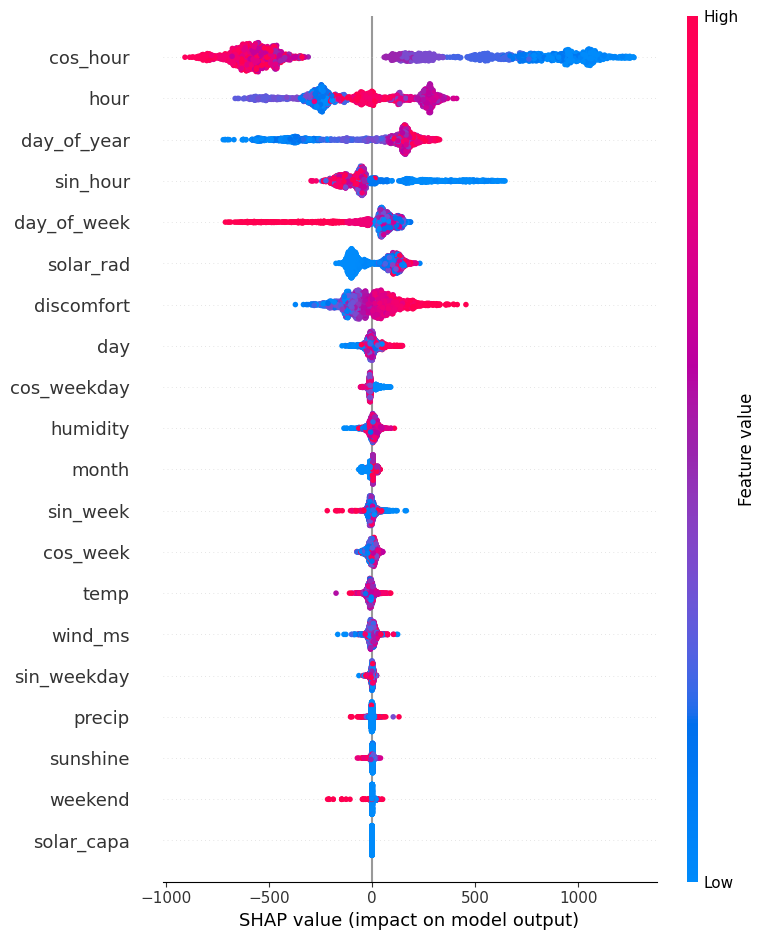

In [ ]:
cols = ['energy_consum', 'date_time', 'building_type']
X = train_df_1.drop(columns=cols, axis=1)
feature_names = X.columns  # 특성의 이름을 저장

y = train_df_1['energy_consum']  # 타겟 변수

# XGBoost 모델 생성
model = XGBRegressor(random_state=42)
model.fit(X, y)

# SHAP 값을 계산
explainer = shap.Explainer(model)
shap_values = explainer(X)

# SHAP 값을 시각화하여 피쳐 중요도 확인
shap.summary_plot(shap_values, X)


In [ ]:
shap_means = np.abs(shap_values.values).mean(axis=0)

# 결과를 DataFrame으로 저장
shap_features = pd.DataFrame({'SHAP Features': feature_names, 'SHAP_mean': shap_means})

# SHAP 평균 순으로 정렬
shap_features = shap_features.sort_values(by='SHAP_mean', ascending=False)
shap_features

,SHAP Features,SHAP_mean
18,cos_hour,637.755066
14,hour,222.690948
16,day_of_year,215.374878
19,sin_hour,140.697495
15,day_of_week,113.172997
6,solar_rad,97.051697
28,discomfort,94.475578
13,day,23.751648
22,cos_weekday,16.791693
4,humidity,16.176184


In [ ]:
mask = shap_features['SHAP_mean'] > 1

shap_columns = shap_features[mask]['SHAP Features'].values



In [ ]:
# train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad']

# train_df_1.drop(columns=train_drop_cols,axis=1).columns

In [ ]:
# test_drop_cols = ['building_num','date_time','building_type']

# test_df_1.drop(columns=test_drop_cols,axis=1).columns

- energy consum은 미리 정의하기

In [ ]:
mask = train_ft['building_num'] == 1

In [ ]:



train_y = train_ft[mask]['energy_consum']

In [ ]:
# train_df_1에서 test_df_1에 없는 피처들을 찾기 (단, 'energy_consum' 피처는 제외)
missing_features = [col for col in train_df_1.columns if col not in test_df_1.columns and col != 'energy_consum']

# train_df_1에서 test_df_1에 없는 피처들을 삭제
train_df_1 = train_df_1.drop(columns=missing_features)

# 삭제된 피처 출력
print("Deleted Features:", missing_features)


Deleted Features: ['sunshine', 'solar_rad']


- feature importance

In [ ]:
from xgboost import XGBRegressor
import numpy as np

In [ ]:
from xgboost import XGBRegressor
import numpy as np

# 데이터 로드 및 전처리
# 예시로 간단한 데이터 생성
cols = ['energy_consum', 'date_time', 'building_type']
X = train_df_1.drop(columns=cols, axis=1)
feature_names = X.columns  # 특성의 이름을 저장

y = train_df_1['energy_consum']  # 타겟 변수

# XGBoost 모델 생성
model = XGBRegressor(random_state=42)
model.fit(X, y)

# 특성 중요도 출력 및 정렬
feature_importances = model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

# print("Feature Importances:")
for i, idx in enumerate(sorted_indices):
    feature_name = feature_names[idx]
    importance = feature_importances[idx]
    # print(f"{i + 1}. Feature: {feature_name}, Importance: {importance:.4f}")

In [ ]:
# 중요도가 높은 특성 10개 선택
top_feature_indices = sorted_indices[:10]
top_feature_names = [feature_names[idx] for idx in top_feature_indices]

# 선택된 특성들로 데이터프레임 업데이트
train_df_1 = train_df_1[top_feature_names]

In [ ]:
def get_important_features(data):
    cols = ['energy_consum', 'date_time', 'building_type']
    X = data.drop(columns=cols, axis=1)
    feature_names = X.columns  # 특성의 이름을 저장

    y = data['energy_consum']  # 타겟 변수

    # XGBoost 모델 생성
    model = XGBRegressor(random_state=42)
    model.fit(X, y)

    # 특성 중요도 출력 및 정렬
    feature_importances = model.feature_importances_
    sorted_indices = np.argsort(feature_importances)[::-1]

    # 중요도가 높은 특성 10개 선택
    top_feature_indices = sorted_indices[:10]
    top_feature_names = [feature_names[idx] for idx in top_feature_indices]

    # 선택된 특성들로 데이터프레임 업데이트
    data = data[top_feature_names]

    return data


In [ ]:
train_df_1 = train_df_1[shap_columns]

In [ ]:
train_df_1

,cos_hour,day_of_year,sin_hour,hour,month,day_of_week,weekend,discomfort,cos_weekday,sin_week
0,1.000000,181,0.000000,0,6,2,0,63.09388,-0.222521,0.120537
1,0.965926,181,0.258819,1,6,2,0,62.46400,-0.222521,0.120537
2,0.866025,181,0.500000,2,6,2,0,62.08735,-0.222521,0.120537
3,0.707107,181,0.707107,3,6,2,0,60.89884,-0.222521,0.120537
4,0.500000,181,0.866025,4,6,2,0,62.88788,-0.222521,0.120537
...,...,...,...,...,...,...,...,...,...,...
2035,0.258819,264,-0.965926,19,8,2,0,73.85035,-0.222521,0.464723
2036,0.500000,264,-0.866025,20,8,2,0,73.44700,-0.222521,0.464723
2037,0.707107,264,-0.707107,21,8,2,0,72.96218,-0.222521,0.464723
2038,0.866025,264,-0.500000,22,8,2,0,72.51230,-0.222521,0.464723


In [ ]:
train_x = train_df_1
test_x = test_df_1[train_x.columns]

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 15), (240, 15), (1800,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

#3.5400384169795878

[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 15
[LightGBM] [Info] Start training from score 2621.660264
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[30]	training's l2: 21797.4	valid_1's l2: 48186.5


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

3.635054808949418

In [ ]:
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
y_pred.shape

[LightGBM] [Info] Total Bins 1142
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 15
[LightGBM] [Info] Start training from score 2653.021410


(168,)

## 건물 2***
- 월요일 휴무 주말 데이터 빼야함
-

- 이상치 처리

In [ ]:
# replaced_values = replace_outliers_with_band(train_df_2)

# for idx, original_value, band_type, replaced_value in replaced_values:
#     train_df_2.loc[idx + 23, 'energy_consum'] = replaced_value

In [ ]:
import seaborn as sns

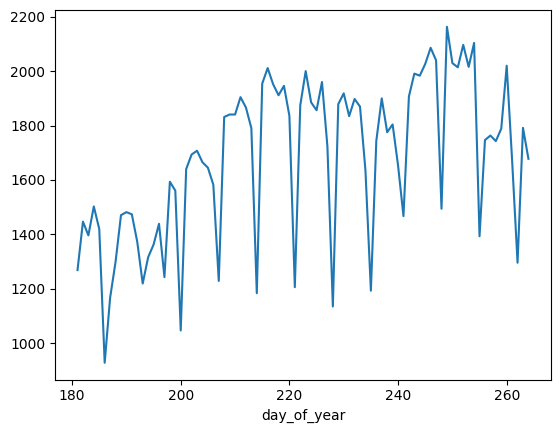

In [ ]:
mean_power_by_day_of_year = train_df_2.groupby('day_of_year')['energy_consum'].mean()
sns.lineplot(x=mean_power_by_day_of_year.index, y=mean_power_by_day_of_year.values)
plt.show()

In [ ]:
import seaborn as sns

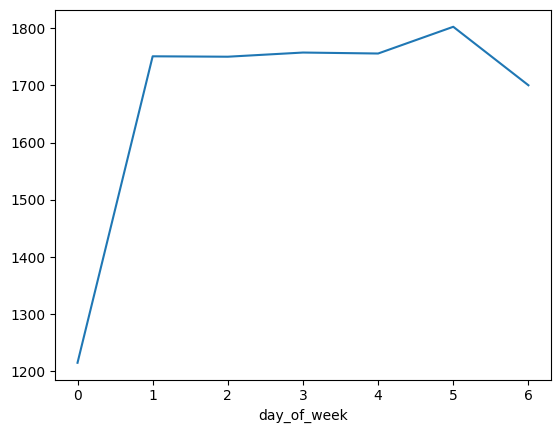

In [ ]:
# 요일별 평균 전력소비량 월(0)~일(6)

mean_power_by_day_of_week = train_df_2.groupby('day_of_week')['energy_consum'].mean()
sns.lineplot(x=mean_power_by_day_of_week.index, y=mean_power_by_day_of_week.values)
plt.show()

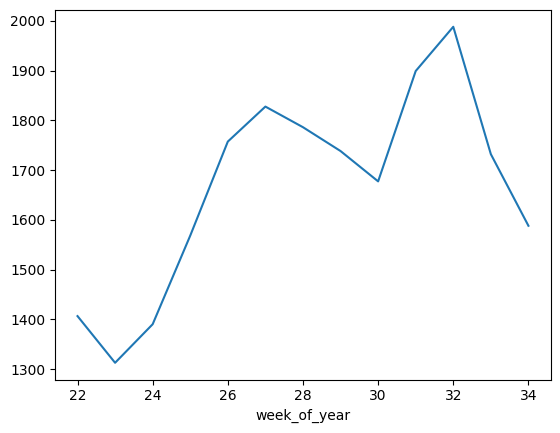

In [ ]:
# 주차별 전력소비량

train_df_2['week_of_year'] = train_df_2['date_time'].dt.isocalendar().week.astype(float)
test_df_2['week_of_year'] = test_df_2['date_time'].dt.isocalendar().week.astype(float)

mean_power_by_day_of_week = train_df_2.groupby('week_of_year')['energy_consum'].mean()
sns.lineplot(x=mean_power_by_day_of_week.index, y=mean_power_by_day_of_week.values)
plt.show()

In [ ]:
#최저점 :

- 칼럼 drop

In [ ]:
train_df_2.columns

Index(['building_num', 'date_time', 'temp', 'precip', 'wind_ms', 'humidity',
       'sunshine', 'solar_rad', 'energy_consum', 'building_type', 'floor_area',
       'cooling_area', 'month', 'day', 'hour', 'day_of_week', 'day_of_year',
       'weekend', 'cos_hour', 'sin_hour', 'cos_day_of_year', 'sin_day_of_year',
       'cos_weekday', 'sin_weekday', 'cos_week', 'sin_week', 'cos_month',
       'sin_month', 'discomfort', 'THI', 'cooling_ratio', 'week_of_year'],
      dtype='object')

In [ ]:
test_df_2.columns

Index(['building_num', 'date_time', 'temp', 'precip', 'wind_ms', 'humidity',
       'building_type', 'floor_area', 'cooling_area', 'month', 'day', 'hour',
       'day_of_week', 'day_of_year', 'weekend', 'cos_hour', 'sin_hour',
       'cos_day_of_year', 'sin_day_of_year', 'cos_weekday', 'sin_weekday',
       'cos_week', 'sin_week', 'cos_month', 'sin_month', 'discomfort', 'THI',
       'cooling_ratio', 'week_of_year'],
      dtype='object')

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad']
test_drop_cols = ['building_num','date_time','building_type']


In [ ]:
train_y = train_df_2['energy_consum']

In [ ]:
# train_df_1에서 test_df_1에 없는 피처들을 찾기 (단, 'energy_consum' 피처는 제외)
missing_features = [col for col in train_df_2.columns if col not in test_df_2.columns and col != 'energy_consum']
# train_df_1에서 test_df_1에 없는 피처들을 삭제
train_df_2 = train_df_2.drop(columns=missing_features)

# 삭제된 피처 출력
print("Deleted Features:", missing_features)


Deleted Features: ['sunshine', 'solar_rad']


In [ ]:
train_df_2 = get_important_features(train_df_2)
train_df_2

,cos_hour,day_of_week,hour,day_of_year,sin_hour,month,sin_weekday,day,cos_weekday,sin_week
2040,1.000000,2,0,181,0.000000,6,0.974928,1,-0.222521,0.120537
2041,0.965926,2,1,181,0.258819,6,0.974928,1,-0.222521,0.120537
2042,0.866025,2,2,181,0.500000,6,0.974928,1,-0.222521,0.120537
2043,0.707107,2,3,181,0.707107,6,0.974928,1,-0.222521,0.120537
2044,0.500000,2,4,181,0.866025,6,0.974928,1,-0.222521,0.120537
...,...,...,...,...,...,...,...,...,...,...
4075,0.258819,2,19,264,-0.965926,8,0.974928,24,-0.222521,0.464723
4076,0.500000,2,20,264,-0.866025,8,0.974928,24,-0.222521,0.464723
4077,0.707107,2,21,264,-0.707107,8,0.974928,24,-0.222521,0.464723
4078,0.866025,2,22,264,-0.500000,8,0.974928,24,-0.222521,0.464723


In [ ]:
train_x = train_df_2
test_x = test_df_2[train_x.columns]

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 10), (240, 10), (1800,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 261
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 10
[LightGBM] [Info] Start training from score 1675.427500
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[14]	training's l2: 44912.5	valid_1's l2: 54812.8


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

5.3190246500351215

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((y_pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1363
[LightGBM] [Info] Number of data points in the train set: 2065, number of used features: 23
[LightGBM] [Info] Start training from score 1668.795957


(336,)

## 건물 3

In [ ]:
test_ft.fillna(0)

,building_num,date_time,temp,precip,wind_ms,humidity,building_type,floor_area,cooling_area,solar_capa,...,sin_day_of_year,cos_weekday,sin_weekday,cos_week,sin_week,cos_month,sin_month,discomfort,THI,cooling_ratio
0,1,2022-06-01 00:00:00,23.5,0.0,2.2,72,건물기타,110634.00,39570.00,0.0,...,0.025818,-0.222521,0.974928,-0.992709,0.120537,-1.0,1.224647e-16,71.78980,71.78980,0.357666
1,1,2022-06-01 01:00:00,23.0,0.0,0.9,72,건물기타,110634.00,39570.00,0.0,...,0.025818,-0.222521,0.974928,-0.992709,0.120537,-1.0,1.224647e-16,71.02840,71.02840,0.357666
2,1,2022-06-01 02:00:00,22.7,0.0,1.5,75,건물기타,110634.00,39570.00,0.0,...,0.025818,-0.222521,0.974928,-0.992709,0.120537,-1.0,1.224647e-16,70.81675,70.81675,0.357666
3,1,2022-06-01 03:00:00,22.1,0.0,1.3,78,건물기타,110634.00,39570.00,0.0,...,0.025818,-0.222521,0.974928,-0.992709,0.120537,-1.0,1.224647e-16,70.11262,70.11262,0.357666
4,1,2022-06-01 04:00:00,21.8,0.0,1.0,77,건물기타,110634.00,39570.00,0.0,...,0.025818,-0.222521,0.974928,-0.992709,0.120537,-1.0,1.224647e-16,69.56514,69.56514,0.357666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,100,2022-06-20 19:00:00,22.5,0.0,0.9,84,호텔및리조트,57497.84,40035.23,0.0,...,-0.296713,1.000000,0.000000,0.568065,-0.822984,-1.0,1.224647e-16,71.22400,71.22400,0.696291
16796,100,2022-06-20 20:00:00,20.7,0.0,0.4,95,호텔및리조트,57497.84,40035.23,0.0,...,-0.296713,1.000000,0.000000,0.568065,-0.822984,-1.0,1.224647e-16,68.95035,68.95035,0.696291
16797,100,2022-06-20 21:00:00,20.2,0.0,0.4,98,호텔및리조트,57497.84,40035.23,0.0,...,-0.296713,1.000000,0.000000,0.568065,-0.822984,-1.0,1.224647e-16,68.24604,68.24604,0.696291
16798,100,2022-06-20 22:00:00,20.1,0.0,1.1,97,호텔및리조트,57497.84,40035.23,0.0,...,-0.296713,1.000000,0.000000,0.568065,-0.822984,-1.0,1.224647e-16,68.01203,68.01203,0.696291


- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_3)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_3.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_y = train_df_3['energy_consum']

missing_features = [col for col in train_df_3.columns if col not in test_df_3.columns and col != 'energy_consum']
# train_df_1에서 test_df_1에 없는 피처들을 삭제
train_df_3 = train_df_3.drop(columns=missing_features)
# 삭제된 피처 출력
print("Deleted Features:", missing_features)


train_df_3 = get_important_features(train_df_3)

train_x = train_df_3
test_x = test_df_3[train_x.columns]

Deleted Features: []


In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1820, 10), (240, 10), (1820,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 389
[LightGBM] [Info] Number of data points in the train set: 1820, number of used features: 10
[LightGBM] [Info] Start training from score 1449.276825
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[57]	training's l2: 10613.1	valid_1's l2: 52980.9


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

5.84475058544071

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 2060, number of used features: 10
[LightGBM] [Info] Start training from score 1439.967379


NameError: ignored

## 건물 4

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_4)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_4.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_4.drop(columns=train_drop_cols,axis=1)
train_y = train_df_4['energy_consum']

test_x = test_df_4.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1805, 24), (240, 24), (1805,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1293
[LightGBM] [Info] Number of data points in the train set: 1805, number of used features: 20
[LightGBM] [Info] Start training from score 988.292693
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[37]	training's l2: 1112.86	valid_1's l2: 5194.09


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

3.0704854834744273

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1353
[LightGBM] [Info] Number of data points in the train set: 2045, number of used features: 20
[LightGBM] [Info] Start training from score 994.536378


(672,)

## 건물 5

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_5)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_5.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_5.drop(columns=train_drop_cols,axis=1)
train_y = train_df_5['energy_consum']

test_x = test_df_5.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1804, 25), (240, 25), (1804,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1293
[LightGBM] [Info] Number of data points in the train set: 1804, number of used features: 20
[LightGBM] [Info] Start training from score 2744.252259
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[38]	training's l2: 52422.3	valid_1's l2: 105312


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

3.9507213456830073

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1353
[LightGBM] [Info] Number of data points in the train set: 2044, number of used features: 20
[LightGBM] [Info] Start training from score 2737.262359


(840,)

## 건물 6

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_6)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_6.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_6.drop(columns=train_drop_cols,axis=1)
train_y = train_df_6['energy_consum']

test_x = test_df_6.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1803, 23), (240, 23), (1803,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1304
[LightGBM] [Info] Number of data points in the train set: 1803, number of used features: 20
[LightGBM] [Info] Start training from score 1956.962663
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[48]	training's l2: 3055.79	valid_1's l2: 20159.4


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

2.156229676330258

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1362
[LightGBM] [Info] Number of data points in the train set: 2043, number of used features: 20
[LightGBM] [Info] Start training from score 1971.644278


(1008,)

## 건물 7***

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_7)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_7.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_7.drop(columns=train_drop_cols,axis=1)
train_y = train_df_7['energy_consum']

test_x = test_df_7.drop(columns=test_drop_cols,axis=1)

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_absolute_error
from sktime.forecasting.model_selection import temporal_train_test_split
from lightgbm import LGBMRegressor

# 데이터 준비 및 전처리 (train_x, train_y, test_x 로드 및 전처리하는 부분은 생략)

# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y=train_y, X=train_x, test_size=240)
x_train_series = torch.tensor(x_train.values, dtype=torch.float32)
x_valid_series = torch.tensor(x_valid.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).view(-1, 1)

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 마지막 시간 스텝의 출력만 사용
        return out

# 모델 및 옵티마이저 생성
model = LSTMModel(input_size=x_train.shape[1], hidden_size=64)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train_series)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# 검증 데이터 예측
model.eval()
with torch.no_grad():
    y_pred_valid = model(x_valid_series).numpy()

# SMAPE 계산 함수
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# 검증 데이터의 SMAPE 계산
smape_score_valid = smape(y_valid.values, y_pred_valid)
print("Validation SMAPE Score:", smape_score_valid)

# 테스트 데이터 예측
test_x_series = torch.tensor(test_x.values, dtype=torch.float32)
model.eval()
with torch.no_grad():
    y_pred_test = model(test_x_series).numpy()

# LGBM 모델 학습 및 예측
lgb_model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
lgb_model.fit(train_x, train_y)
y_pred_lgb = lgb_model.predict(test_x)

# 두 모델의 예측값 비율 조정
y_pred_final = 0.5 * y_pred_test + 0.5 * y_pred_lgb

# 결과 저장
submission = pd.DataFrame({'id': test_x.index, 'pred': y_pred_final})
submission.to_csv('submission.csv', index=False)


NameError: ignored

In [ ]:
import lightgbm as lgb
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
import numpy as np

# 데이터 로드 및 전처리
# train_ft와 test_ft 데이터를 가져오고 전처리하는 과정이 필요합니다.

# 학습 데이터와 검증 데이터로 분할
x_train, x_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.1, random_state=42)

# LGBM 모델 학습
model = lgb.LGBMRegressor(random_state=42)
model.fit(x_train, y_train)

# 각 feature의 중요도 추출
feature_importances = model.feature_importances_

# 중요도를 기준으로 내림차순으로 feature의 index 정렬
sorted_feature_indices = np.argsort(feature_importances)[::-1]

# KBest로 선택할 feature의 개수 설정
k = 10

# KBest 선택기 생성
k_best_selector = SelectKBest(score_func=f_regression, k=k)

# 선택된 feature 추출
selected_features = k_best_selector.fit_transform(x_train, y_train)

# # 선택된 feature의 index 추출
# selected_feature_indices = sorted_feature_indices[:k]

# # 검증 데이터에서도 선택된 feature만 추출
# selected_valid_features = x_valid.iloc[:, selected_feature_indices]



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1368
[LightGBM] [Info] Number of data points in the train set: 1893, number of used features: 25
[LightGBM] [Info] Start training from score 764.738040


ValueError: ignored

In [ ]:
selected_features

array([[ 3.01000000e+01,  7.00000000e+00,  1.70000000e+01, ...,
        -5.00000000e-01,  7.98254100e+01,  7.98254100e+01],
       [ 3.24000000e+01,  8.00000000e+00,  1.60000000e+01, ...,
        -8.66025404e-01,  8.08987200e+01,  8.08987200e+01],
       [ 2.73000000e+01,  6.00000000e+00,  2.00000000e+01, ...,
         1.22464680e-16,  7.85946000e+01,  7.85946000e+01],
       ...,
       [ 3.18000000e+01,  7.00000000e+00,  2.00000000e+01, ...,
        -5.00000000e-01,  8.35699400e+01,  8.35699400e+01],
       [ 2.67000000e+01,  7.00000000e+00,  1.90000000e+01, ...,
        -5.00000000e-01,  7.90893600e+01,  7.90893600e+01],
       [ 2.55000000e+01,  7.00000000e+00,  2.20000000e+01, ...,
        -5.00000000e-01,  7.45070500e+01,  7.45070500e+01]])

In [ ]:
from lightgbm import LGBMRegressor

# 선택된 피쳐의 인덱스 추출
selected_indices = k_best_selector.get_support(indices=True)

# 선택된 피쳐들로 새로운 데이터프레임 생성
selected_train_features = x_train.iloc[:, selected_indices]
selected_valid_features = x_valid.iloc[:, selected_indices]

# 모델 학습
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(selected_train_features, y_train, eval_set=[(selected_train_features, y_train), (selected_valid_features, y_valid)])

# 검증 데이터 예측
y_pred = model.predict(selected_valid_features)


def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# 검증 데이터의 SMAPE 계산
smape_score = smape(y_valid, y_pred)
print("Validation SMAPE Score:", smape_score)

[LightGBM] [Info] Total Bins 915
[LightGBM] [Info] Number of data points in the train set: 1836, number of used features: 10
[LightGBM] [Info] Start training from score 1674.863726
Validation SMAPE Score: 8.584650292199653


In [ ]:
selected_feature_names = x_train.columns[selected_indices]
print("Selected Feature Names:", selected_feature_names)

Selected Feature Names: Index(['temp', 'month', 'hour', 'day_of_year', 'cos_hour', 'sin_hour',
       'sin_day_of_year', 'sin_month', 'discomfort', 'THI'],
      dtype='object')


In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1864, 25), (240, 25), (1864,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1315
[LightGBM] [Info] Number of data points in the train set: 1864, number of used features: 20
[LightGBM] [Info] Start training from score 780.322790
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[64]	training's l2: 1259.79	valid_1's l2: 48614.8


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

12.196554227587008

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1377
[LightGBM] [Info] Number of data points in the train set: 2104, number of used features: 25
[LightGBM] [Info] Start training from score 760.941873


(1176,)

## 건물 8

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_8)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_8.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','precip'] #solar rad 없음
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_df_8.columns

Index(['building_num', 'date_time', 'temp', 'precip', 'wind_ms', 'humidity',
       'sunshine', 'energy_consum', 'building_type', 'floor_area',
       'cooling_area', 'month', 'day', 'hour', 'day_of_week', 'day_of_year',
       'cos_hour', 'sin_hour', 'cos_day_of_year', 'sin_day_of_year',
       'cos_weekday', 'sin_weekday', 'cos_week', 'sin_week', 'cos_month',
       'sin_month', 'discomfort', 'THI', 'cooling_ratio'],
      dtype='object')

In [ ]:
train_x = train_df_8.drop(columns=train_drop_cols,axis=1)
train_y = train_df_8['energy_consum']

test_x = test_df_8.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1891, 23), (240, 23), (1891,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1305
[LightGBM] [Info] Number of data points in the train set: 1891, number of used features: 20
[LightGBM] [Info] Start training from score 1326.023607
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[77]	training's l2: 1531.21	valid_1's l2: 12246.8


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

3.6084711952828386

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1359
[LightGBM] [Info] Number of data points in the train set: 2131, number of used features: 23
[LightGBM] [Info] Start training from score 1317.380234


(1344,)

## 건물 9

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_9)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_9.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_9.drop(columns=train_drop_cols,axis=1)
train_y = train_df_9['energy_consum']

test_x = test_df_9.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1852, 23), (240, 23), (1852,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1320
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 20
[LightGBM] [Info] Start training from score 2324.360864
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[38]	training's l2: 4868.82	valid_1's l2: 13752.4


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

2.5163777405452716

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1375
[LightGBM] [Info] Number of data points in the train set: 2092, number of used features: 23
[LightGBM] [Info] Start training from score 2314.820139


(1512,)

## 건물 10

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_10)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_2.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_10.drop(columns=train_drop_cols,axis=1)
train_y = train_df_10['energy_consum']

test_x = test_df_10.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1816, 23), (240, 23), (1816,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1312
[LightGBM] [Info] Number of data points in the train set: 1816, number of used features: 20
[LightGBM] [Info] Start training from score 4048.277049
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[29]	training's l2: 20700.2	valid_1's l2: 127115


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

3.5958674686294776

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1371
[LightGBM] [Info] Number of data points in the train set: 2056, number of used features: 20
[LightGBM] [Info] Start training from score 4054.513458


(1680,)

## 건물 11

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_11)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_11.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','precip'] #solar_rad
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_11.drop(columns=train_drop_cols,axis=1)
train_y = train_df_11['energy_consum']

test_x = test_df_11.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1805, 24), (240, 24), (1805,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1293
[LightGBM] [Info] Number of data points in the train set: 1805, number of used features: 20
[LightGBM] [Info] Start training from score 1927.580941
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[74]	training's l2: 1973.97	valid_1's l2: 11057.3


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

1.8777286024350508

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1350
[LightGBM] [Info] Number of data points in the train set: 2045, number of used features: 20
[LightGBM] [Info] Start training from score 1929.349082


(1848,)

## 건물 12

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_12)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_12.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_12.drop(columns=train_drop_cols,axis=1)
train_y = train_df_12['energy_consum']

test_x = test_df_12.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1833, 24), (240, 24), (1833,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 1833, number of used features: 20
[LightGBM] [Info] Start training from score 1432.420850
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[37]	training's l2: 1817.54	valid_1's l2: 8162.19


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

2.1516533762097483

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1374
[LightGBM] [Info] Number of data points in the train set: 2073, number of used features: 24
[LightGBM] [Info] Start training from score 1438.157744


(2016,)

## 건물 13

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_13)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_13.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_13.drop(columns=train_drop_cols,axis=1)
train_y = train_df_13['energy_consum']

test_x = test_df_13.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1840, 23), (240, 23), (1840,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1317
[LightGBM] [Info] Number of data points in the train set: 1840, number of used features: 20
[LightGBM] [Info] Start training from score 2529.911348
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[15]	training's l2: 25781	valid_1's l2: 32191.9


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

2.9772368830641605

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1380
[LightGBM] [Info] Number of data points in the train set: 2080, number of used features: 23
[LightGBM] [Info] Start training from score 2526.586211


(2184,)

## 건물 14***

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_14)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_14.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_14.drop(columns=train_drop_cols,axis=1)
train_y = train_df_14['energy_consum']

test_x = test_df_14.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1904, 24), (240, 24), (1904,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1309
[LightGBM] [Info] Number of data points in the train set: 1904, number of used features: 20
[LightGBM] [Info] Start training from score 1916.145629
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[40]	training's l2: 35926	valid_1's l2: 124441


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

9.152098810809312

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1362
[LightGBM] [Info] Number of data points in the train set: 2144, number of used features: 24
[LightGBM] [Info] Start training from score 1881.260710


(2352,)

## 건물 15

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_2)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_2.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_2.drop(columns=train_drop_cols,axis=1)
train_y = train_df_2['energy_consum']

test_x = test_df_2.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1839, 23), (240, 23), (1839,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1302
[LightGBM] [Info] Number of data points in the train set: 1839, number of used features: 20
[LightGBM] [Info] Start training from score 1671.782741
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[8]	training's l2: 97214.1	valid_1's l2: 400804


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

10.27823663579252

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1363
[LightGBM] [Info] Number of data points in the train set: 2079, number of used features: 23
[LightGBM] [Info] Start training from score 1682.451524


(2520,)

## 건물 16

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_16)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_16.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_16.drop(columns=train_drop_cols,axis=1)
train_y = train_df_16['energy_consum']

test_x = test_df_16.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((2069, 24), (240, 24), (2069,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1351
[LightGBM] [Info] Number of data points in the train set: 2069, number of used features: 24
[LightGBM] [Info] Start training from score 3376.703843
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[23]	training's l2: 41754.5	valid_1's l2: 21273.6


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

4.155723661471707

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1351
[LightGBM] [Info] Number of data points in the train set: 2309, number of used features: 24
[LightGBM] [Info] Start training from score 3185.959034


(2688,)

## 건물 17***

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_17)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_17.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_17.drop(columns=train_drop_cols,axis=1)
train_y = train_df_17['energy_consum']

test_x = test_df_17.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1828, 23), (240, 23), (1828,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1301
[LightGBM] [Info] Number of data points in the train set: 1828, number of used features: 20
[LightGBM] [Info] Start training from score 966.001756
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[22]	training's l2: 6168.63	valid_1's l2: 50751.8


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

7.323938536043037

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1362
[LightGBM] [Info] Number of data points in the train set: 2068, number of used features: 23
[LightGBM] [Info] Start training from score 971.891331


(2856,)

## 건물 18

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_18)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_18.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_18.drop(columns=train_drop_cols,axis=1)
train_y = train_df_18['energy_consum']

test_x = test_df_18.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1808, 24), (240, 24), (1808,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1304
[LightGBM] [Info] Number of data points in the train set: 1808, number of used features: 20
[LightGBM] [Info] Start training from score 1436.611643
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[24]	training's l2: 7280.37	valid_1's l2: 48702.9


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

4.276641306583906

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1362
[LightGBM] [Info] Number of data points in the train set: 2048, number of used features: 20
[LightGBM] [Info] Start training from score 1451.678989


(3024,)

## 건물 19

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_19)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_19.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_19.drop(columns=train_drop_cols,axis=1)
train_y = train_df_19['energy_consum']

test_x = test_df_19.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1813, 25), (240, 25), (1813,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1294
[LightGBM] [Info] Number of data points in the train set: 1813, number of used features: 20
[LightGBM] [Info] Start training from score 1408.483559
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[22]	training's l2: 12243.6	valid_1's l2: 68226.9


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

6.724716697470674

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1353
[LightGBM] [Info] Number of data points in the train set: 2053, number of used features: 20
[LightGBM] [Info] Start training from score 1419.024466


(3192,)

## 건물 20

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_20)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_20.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','precip'] #solar_rad
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_20.drop(columns=train_drop_cols,axis=1)
train_y = train_df_20['energy_consum']

test_x = test_df_20.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 23), (240, 23), (1800,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1285
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 20
[LightGBM] [Info] Start training from score 1708.765068
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[22]	training's l2: 18994	valid_1's l2: 254940


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

6.953786391103097

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1326
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 20
[LightGBM] [Info] Start training from score 1722.787530


(3360,)

## 건물 21

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_21)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_21.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_21.drop(columns=train_drop_cols,axis=1)
train_y = train_df_21['energy_consum']

test_x = test_df_21.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1801, 26), (240, 26), (1801,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1283
[LightGBM] [Info] Number of data points in the train set: 1801, number of used features: 20
[LightGBM] [Info] Start training from score 1973.311429
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[22]	training's l2: 19137.9	valid_1's l2: 95941.7


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

5.051542080490981

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1340
[LightGBM] [Info] Number of data points in the train set: 2041, number of used features: 20
[LightGBM] [Info] Start training from score 1988.770845


(3528,)

## 건물 22

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_22)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_22.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_22.drop(columns=train_drop_cols,axis=1)
train_y = train_df_22['energy_consum']

test_x = test_df_22.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1822, 24), (240, 24), (1822,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1279
[LightGBM] [Info] Number of data points in the train set: 1822, number of used features: 20
[LightGBM] [Info] Start training from score 1230.799496
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[37]	training's l2: 1812.38	valid_1's l2: 16178.9


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

3.524159298890983

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1348
[LightGBM] [Info] Number of data points in the train set: 2062, number of used features: 24
[LightGBM] [Info] Start training from score 1232.508255


(3696,)

## 건물 23

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_23)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_23.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_23.drop(columns=train_drop_cols,axis=1)
train_y = train_df_23['energy_consum']

test_x = test_df_23.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1804, 23), (240, 23), (1804,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 1804, number of used features: 20
[LightGBM] [Info] Start training from score 1259.223393
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[24]	training's l2: 1225.03	valid_1's l2: 17194.5


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

2.5118269370371262

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1335
[LightGBM] [Info] Number of data points in the train set: 2044, number of used features: 20
[LightGBM] [Info] Start training from score 1263.823594


(3864,)

## 건물 24

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_24)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_24.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_24.drop(columns=train_drop_cols,axis=1)
train_y = train_df_24['energy_consum']

test_x = test_df_24.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1802, 24), (240, 24), (1802,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1291
[LightGBM] [Info] Number of data points in the train set: 1802, number of used features: 20
[LightGBM] [Info] Start training from score 9993.332965
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[20]	training's l2: 233672	valid_1's l2: 1.43432e+06


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

2.912555745280679

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1353
[LightGBM] [Info] Number of data points in the train set: 2042, number of used features: 20
[LightGBM] [Info] Start training from score 10041.156217


(4032,)

## 건물 25

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_25)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_25.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_25.drop(columns=train_drop_cols,axis=1)
train_y = train_df_25['energy_consum']

test_x = test_df_25.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 24), (240, 24), (1800,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1289
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 20
[LightGBM] [Info] Start training from score 7229.745061
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[23]	training's l2: 106285	valid_1's l2: 1.01396e+06


/usr/local/lib/python3.10/dist-packages/IPython/core/displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

3.098230579975161

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1335
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 20
[LightGBM] [Info] Start training from score 7264.323584


(4200,)

## 건물 26

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_26)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_26.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_26.drop(columns=train_drop_cols,axis=1)
train_y = train_df_26['energy_consum']

test_x = test_df_26.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 24), (240, 24), (1800,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1297
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 20
[LightGBM] [Info] Start training from score 3518.006933
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[22]	training's l2: 26985.4	valid_1's l2: 155628


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

2.649225475215552

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1339
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 20
[LightGBM] [Info] Start training from score 3529.790117


(4368,)

## 건물 27

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_27)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_27.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_27.drop(columns=train_drop_cols,axis=1)
train_y = train_df_27['energy_consum']

test_x = test_df_27.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 24), (240, 24), (1800,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 20
[LightGBM] [Info] Start training from score 17397.379988
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[17]	training's l2: 540658	valid_1's l2: 1.63696e+06


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

1.9544426929689738

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1339
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 20
[LightGBM] [Info] Start training from score 17453.642143


(4536,)

## 건물 28

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_28)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_28.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','precip'] #solar_rad
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_28.drop(columns=train_drop_cols,axis=1)
train_y = train_df_28['energy_consum']

test_x = test_df_28.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1810, 24), (240, 24), (1810,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1291
[LightGBM] [Info] Number of data points in the train set: 1810, number of used features: 20
[LightGBM] [Info] Start training from score 1734.283094
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[21]	training's l2: 18093.2	valid_1's l2: 48154.3


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

3.79769854312523

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1350
[LightGBM] [Info] Number of data points in the train set: 2050, number of used features: 20
[LightGBM] [Info] Start training from score 1728.555457


(4704,)

## 건물 29

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_29)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_29.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','precip'] #solar_rad
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_29.drop(columns=train_drop_cols,axis=1)
train_y = train_df_29['energy_consum']

test_x = test_df_29.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1808, 24), (240, 24), (1808,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 1808, number of used features: 20
[LightGBM] [Info] Start training from score 1448.236311
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[13]	training's l2: 16755.6	valid_1's l2: 44423.9


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

4.312418138865363

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1348
[LightGBM] [Info] Number of data points in the train set: 2048, number of used features: 20
[LightGBM] [Info] Start training from score 1448.941765


(4872,)

## 건물 30***

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_30)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_30.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_30.drop(columns=train_drop_cols,axis=1)
train_y = train_df_30['energy_consum']

test_x = test_df_30.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1840, 24), (240, 24), (1840,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1296
[LightGBM] [Info] Number of data points in the train set: 1840, number of used features: 20
[LightGBM] [Info] Start training from score 837.597799
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 986.527	valid_1's l2: 25217.6


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

7.513455731648783

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1359
[LightGBM] [Info] Number of data points in the train set: 2080, number of used features: 24
[LightGBM] [Info] Start training from score 833.614237


(5040,)

## 건물 31

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_31)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_31.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_31.drop(columns=train_drop_cols,axis=1)
train_y = train_df_31['energy_consum']

test_x = test_df_31.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1812, 24), (240, 24), (1812,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 1812, number of used features: 20
[LightGBM] [Info] Start training from score 1355.648045
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[38]	training's l2: 2515.07	valid_1's l2: 21017.3


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

3.3203106064483565

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1358
[LightGBM] [Info] Number of data points in the train set: 2052, number of used features: 20
[LightGBM] [Info] Start training from score 1353.470236


(5208,)

## 건물 32

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_32)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_32.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_32.drop(columns=train_drop_cols,axis=1)
train_y = train_df_32['energy_consum']

test_x = test_df_32.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 23), (240, 23), (1800,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1290
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 20
[LightGBM] [Info] Start training from score 9861.091387
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[68]	training's l2: 354.865	valid_1's l2: 2978.88


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

0.21712358857586211

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 20
[LightGBM] [Info] Start training from score 9865.783576


(5376,)

## 건물 33

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_33)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_33.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_33.drop(columns=train_drop_cols,axis=1)
train_y = train_df_33['energy_consum']

test_x = test_df_33.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1800, 23), (240, 23), (1800,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1289
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 20
[LightGBM] [Info] Start training from score 8689.485592
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 195.509	valid_1's l2: 1612.6


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

0.18471761663300343

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1335
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 20
[LightGBM] [Info] Start training from score 8700.811057


(5544,)

## 건물 34

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_34)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_34.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_34.drop(columns=train_drop_cols,axis=1)
train_y = train_df_34['energy_consum']

test_x = test_df_34.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1801, 23), (240, 23), (1801,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1291
[LightGBM] [Info] Number of data points in the train set: 1801, number of used features: 20
[LightGBM] [Info] Start training from score 3348.646440
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[57]	training's l2: 362.917	valid_1's l2: 1013.89


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

0.34404951362998276

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1353
[LightGBM] [Info] Number of data points in the train set: 2041, number of used features: 20
[LightGBM] [Info] Start training from score 3352.664958


(5712,)

## 건물 35

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_35)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_35.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_35.drop(columns=train_drop_cols,axis=1)
train_y = train_df_35['energy_consum']

test_x = test_df_35.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1805, 23), (240, 23), (1805,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1293
[LightGBM] [Info] Number of data points in the train set: 1805, number of used features: 20
[LightGBM] [Info] Start training from score 2170.705264
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[27]	training's l2: 75.9475	valid_1's l2: 247.347


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

0.27707922048394196

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1353
[LightGBM] [Info] Number of data points in the train set: 2045, number of used features: 20
[LightGBM] [Info] Start training from score 2172.250901


(5880,)

## 건물 36

- 이상치 처리

In [ ]:
replaced_values = replace_outliers_with_band(train_df_36)

for idx, original_value, band_type, replaced_value in replaced_values:
    train_df_36.loc[idx + 23, 'energy_consum'] = replaced_value

- 칼럼 drop

In [ ]:
train_drop_cols = ['energy_consum','building_num','date_time','building_type','sunshine','solar_rad','precip']
test_drop_cols = ['building_num','date_time','building_type','precip']

In [ ]:
train_x = train_df_36.drop(columns=train_drop_cols,axis=1)
train_y = train_df_36['energy_consum']

test_x = test_df_36.drop(columns=test_drop_cols,axis=1)

In [ ]:
# 마지막 10일을 검증셋으로 설정
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = train_y, X = train_x, test_size = 240)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((1811, 23), (240, 23), (1811,), (240,))

In [ ]:
model = LGBMRegressor(random_state=SEED, objective='regression', force_row_wise=True)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], callbacks = [early_stopping(300)])

[LightGBM] [Info] Total Bins 1304
[LightGBM] [Info] Number of data points in the train set: 1811, number of used features: 20
[LightGBM] [Info] Start training from score 2891.990391
Training until validation scores don't improve for 300 rounds
Did not meet early stopping. Best iteration is:
[86]	training's l2: 44.0207	valid_1's l2: 768.1


LGBMRegressor(force_row_wise=True, objective='regression', random_state=42)

In [ ]:
x_pred = model.predict(x_valid)
x_pred = pd.Series(x_pred)
# x_pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
# plot_series(y_train, y_valid, pd.Series(x_pred), markers=[',' , ',', ','])

In [ ]:
_smape(y_valid, x_pred)

0.3740976985043156

In [ ]:
model.fit(train_x, train_y)
pred = np.concatenate((pred, model.predict(test_x)))
pred.shape

[LightGBM] [Info] Total Bins 1362
[LightGBM] [Info] Number of data points in the train set: 2051, number of used features: 20
[LightGBM] [Info] Start training from score 2892.629258


(6048,)

In [ ]:
test_ft.shape

(16800, 30)

In [ ]:
mask = test['건물번호'] == 36
test[mask]

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
5880,36_20220825 00,36,20220825 00,22.8,0.0,1.1,75
5881,36_20220825 01,36,20220825 01,22.6,0.0,1.0,75
5882,36_20220825 02,36,20220825 02,22.2,0.0,1.0,77
5883,36_20220825 03,36,20220825 03,21.4,0.0,1.0,83
5884,36_20220825 04,36,20220825 04,21.2,0.0,0.3,85
...,...,...,...,...,...,...,...
6043,36_20220831 19,36,20220831 19,22.4,0.0,1.1,84
6044,36_20220831 20,36,20220831 20,21.5,0.0,0.8,86
6045,36_20220831 21,36,20220831 21,21.8,0.0,0.9,86
6046,36_20220831 22,36,20220831 22,21.1,0.0,0.4,93


In [ ]:
submission.iloc[:6048]

,num_date_time,answer
0,1_20220825 00,0
1,1_20220825 01,0
2,1_20220825 02,0
3,1_20220825 03,0
4,1_20220825 04,0
...,...,...
6043,36_20220831 19,0
6044,36_20220831 20,0
6045,36_20220831 21,0
6046,36_20220831 22,0


In [ ]:
len(pred)

6048

In [ ]:
submission.iloc[:6048,1] = pred

In [ ]:
submission.iloc[:6048]

,num_date_time,answer
0,1_20220825 00,1051.134133
1,1_20220825 01,1014.054625
2,1_20220825 02,1010.312740
3,1_20220825 03,1003.938728
4,1_20220825 04,997.774250
...,...,...
6043,36_20220831 19,2878.042448
6044,36_20220831 20,2882.184163
6045,36_20220831 21,2879.621748
6046,36_20220831 22,2870.958227


In [ ]:
submission.to_csv('submission_1_36.csv', index=False)

In [ ]:
baseline_sub = pd.read_csv(f'{DATA_PATH}baseline_submission.csv')

In [ ]:
sub_1_36 = pd.read_csv(f'{DATA_PATH}submission_1_36.csv')

In [ ]:
mask = test_ft['건물번호'] ==

In [ ]:
baseline_sub.iloc[4:7,1] = sub_1_36.iloc[4:7,1]

In [ ]:
baseline_sub.iloc[8:14,1] = sub_1_36.iloc[8:14,1]

In [ ]:
baseline_sub.iloc[22:29,1] = sub_1_36.iloc[22:29,1]

In [ ]:
baseline_sub.iloc[31:36,1] = sub_1_36.iloc[31:36,1]

In [ ]:
pd.to_csv('baseline_sub.csv')

,num_date_time,answer
0,1_20220825 00,2085.68640
1,1_20220825 01,2079.40320
2,1_20220825 02,2010.55680
3,1_20220825 03,1969.79040
4,1_20220825 04,997.77425
...,...,...
16795,100_20220831 19,888.57360
16796,100_20220831 20,774.27360
16797,100_20220831 21,722.45040
16798,100_20220831 22,642.66000


In [ ]:
baseline_sub.to_csv('baseline_1-36LGBMconcat.csv', index=False)
